#COVID-19 Patient Symptoms & Diagnosis

#Problem Statement:

The objective of this analysis is to predict COVID-19 diagnosis (positive or negative) in patients based on their symptoms and demographic data. This involves identifying key factors influencing diagnosis and developing classification models to accurately classify patients. The dataset, "covid19_patient_symptoms_diagnosis.csv", contains patient information such as age, gender, various symptoms (fever, dry cough, sore throat, fatigue, headache, shortness of breath, loss of smell, loss of taste, chest pain), physiological measurements (oxygen level, body temperature), comorbidity, and travel/contact history.

The system aims to maximize recall to minimize missed positive cases while maintaining reliable probability estimates for informed decision-making.

In [59]:
#Data manipulaion
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Model selection and evaluation
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score,recall_score,f1_score,log_loss,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc

# Preprocessing
from sklearn.preprocessing import StandardScaler,MultiLabelBinarizer
from imblearn.combine import SMOTETomek
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

# joblib
import joblib

# warnings
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported Successfully!")

All libraries imported Successfully!


## Load and explore dataset

In [60]:
# Loading Dataset
data=pd.read_csv("/content/covid19_patient_symptoms_diagnosis.csv")

The dataset contains the following columns:

*   **patient_id**: Unique identifier for each patient.
*   **age**: Age of the patient.
*   **gender**: Gender of the patient (Male/Female).
*   **fever**: Indicates if the patient has a fever (1 for Yes, 0 for No).
*   **dry_cough**: Indicates if the patient has a dry cough (1 for Yes, 0 for No).
*   **sore_throat**: Indicates if the patient has a sore throat (1 for Yes, 0 for No).
*   **fatigue**: Indicates if the patient experiences fatigue (1 for Yes, 0 for No).
*   **headache**: Indicates if the patient has a headache (1 for Yes, 0 for No).
*   **shortness_of_breath**: Indicates if the patient has shortness of breath (1 for Yes, 0 for No).
*   **loss_of_smell**: Indicates if the patient has loss of smell (1 for Yes, 0 for No).
*   **loss_of_taste**: Indicates if the patient has loss of taste (1 for Yes, 0 for No).
*   **oxygen_level**: Oxygen saturation level of the patient.
*   **body_temperature**: Body temperature of the patient in Celsius.
*   **comorbidity**: Pre-existing health conditions (Diabetes, Asthma, Heart Disease, or Unknown).
*   **travel_history**: Indicates if the patient has a travel history (1 for Yes, 0 for No).
*   **contact_with_patient**: Indicates if the patient had contact with a COVID-19 patient (1 for Yes, 0 for No).
*   **chest_pain**: Indicates if the patient has chest pain (1 for Yes, 0 for No).
*   **covid_result**: The COVID-19 test result (1 for Positive, 0 for Negative).

In [61]:
#creating copy
df=data.copy()

In [62]:
#Dataset columns
df.columns

Index(['patient_id', 'age', 'gender', 'fever', 'dry_cough', 'sore_throat',
       'fatigue', 'headache', 'shortness_of_breath', 'loss_of_smell',
       'loss_of_taste', 'oxygen_level', 'body_temperature', 'comorbidity',
       'travel_history', 'contact_with_patient', 'chest_pain', 'covid_result'],
      dtype='object')

In [63]:
#Top 5 rows
df.head()

,patient_id,age,gender,fever,dry_cough,sore_throat,fatigue,headache,shortness_of_breath,loss_of_smell,loss_of_taste,oxygen_level,body_temperature,comorbidity,travel_history,contact_with_patient,chest_pain,covid_result
0,1,52,Male,1,0,1,1,0,0,0,0,98,37.1,Diabetes,0,0,0,0
1,2,15,Male,0,0,0,1,1,0,0,0,85,37.7,Diabetes,0,1,0,0
2,3,72,Male,1,0,1,0,0,1,0,1,99,36.8,NaN,0,0,0,0
3,4,61,Female,0,0,1,1,1,0,1,1,86,36.0,NaN,1,0,0,0
4,5,21,Female,1,1,0,0,0,1,0,1,90,36.4,NaN,1,1,1,1


In [64]:
# Uniques values of each column
for i in df.columns:
  print(f"{i}: {df[i].unique()}")
  print()

patient_id: [   1    2    3 ... 4998 4999 5000]

age: [52 15 72 61 21 83 87 75 88 24  3 22 53  2 30 38 64 60 33 76 58 89 49 59
 42 80 62 47 51 55  7 73 39 18  4 14  9 84 71 44  8 35 78 81 36 50  6 54
 63 34 74 48 40 85 82 26 41 29 45 65  1 11  5 28 12 23 37 86 27 79 77 43
 13 32 66 57 70 56 19 68 17 69 16 20 67 31 25 46 10]

gender: ['Male' 'Female']

fever: [1 0]

dry_cough: [0 1]

sore_throat: [1 0]

fatigue: [1 0]

headache: [0 1]

shortness_of_breath: [0 1]

loss_of_smell: [0 1]

loss_of_taste: [0 1]

oxygen_level: [98 85 99 86 90 94 89 93 97 91 96 87 88 92 95]

body_temperature: [37.1 37.7 36.8 36.  36.4 39.8 36.2 38.  40.9 40.  37.4 39.2 38.5 39.1
 38.2 38.7 37.6 38.6 38.1 39.3 39.9 36.9 40.4 40.3 38.8 36.6 37.8 40.2
 36.1 39.  36.5 37.3 39.4 40.8 40.5 38.9 39.6 37.5 37.9 40.7 41.  36.7
 39.7 37.2 38.3 39.5 38.4 36.3 37.  40.6 40.1]

comorbidity: ['Diabetes' nan 'Asthma' 'Heart Disease']

travel_history: [0 1]

contact_with_patient: [0 1]

chest_pain: [0 1]

covid_result: [0 1]



In [65]:
# Rows and Columns
print("Dataset Shape",df.shape)
print("Number of Rows",df.shape[0])
print("Number of Columns",df.shape[1])

Dataset Shape (5000, 18)
Number of Rows 5000
Number of Columns 18


In [66]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   patient_id            5000 non-null   int64  
 1   age                   5000 non-null   int64  
 2   gender                5000 non-null   object 
 3   fever                 5000 non-null   int64  
 4   dry_cough             5000 non-null   int64  
 5   sore_throat           5000 non-null   int64  
 6   fatigue               5000 non-null   int64  
 7   headache              5000 non-null   int64  
 8   shortness_of_breath   5000 non-null   int64  
 9   loss_of_smell         5000 non-null   int64  
 10  loss_of_taste         5000 non-null   int64  
 11  oxygen_level          5000 non-null   int64  
 12  body_temperature      5000 non-null   float64
 13  comorbidity           2275 non-null   object 
 14  travel_history        5000 non-null   int64  
 15  contact_with_patient 

In [67]:
#Statistical description
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,5000.0,2500.50000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
age,5000.0,44.38060,25.551632,1.0,22.00,44.0,66.00,89.0
fever,5000.0,0.56740,0.495486,0.0,0.00,1.0,1.00,1.0
dry_cough,5000.0,0.49320,0.500004,0.0,0.00,0.0,1.00,1.0
sore_throat,5000.0,0.41600,0.492943,0.0,0.00,0.0,1.00,1.0
fatigue,5000.0,0.58980,0.491919,0.0,0.00,1.0,1.00,1.0
headache,5000.0,0.44480,0.496993,0.0,0.00,0.0,1.00,1.0
shortness_of_breath,5000.0,0.34840,0.476511,0.0,0.00,0.0,1.00,1.0
loss_of_smell,5000.0,0.29940,0.458041,0.0,0.00,0.0,1.00,1.0
loss_of_taste,5000.0,0.29280,0.455093,0.0,0.00,0.0,1.00,1.0


In [68]:
# Checking null values
df.isnull().sum()

,0
patient_id,0
age,0
gender,0
fever,0
dry_cough,0
sore_throat,0
fatigue,0
headache,0
shortness_of_breath,0
loss_of_smell,0


In [69]:
# Handling null values
df['comorbidity'].fillna('Unknown', inplace=True)

In [70]:
# Duplicate values
df.duplicated().sum()

np.int64(0)

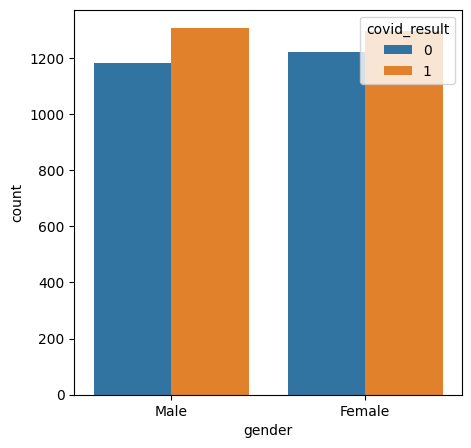

In [71]:
# Gender count
plt.figure(figsize=(5,5))
sns.countplot(data=df,x='gender',hue='covid_result')
plt.show()

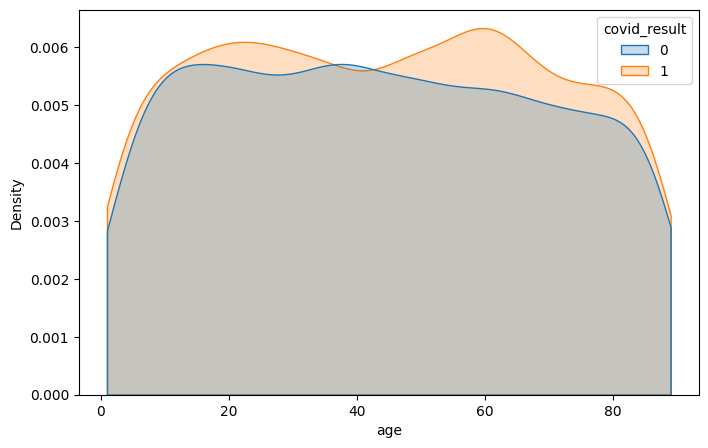

In [72]:
# age distribution based on covid results
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='age', hue='covid_result',clip=(df.age.min(),df.age.max()), fill=True)
plt.show()

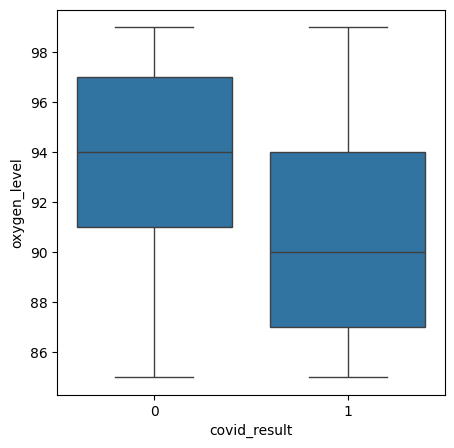

In [73]:
# oxygen level vs covid results
plt.figure(figsize=(5,5))
sns.boxplot(x='covid_result', y='oxygen_level', data=df)
plt.show()

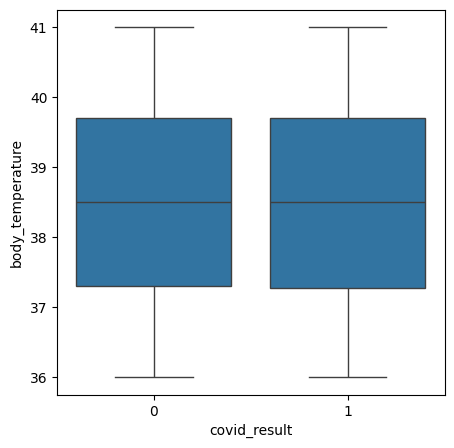

In [74]:
# body temperature vs covid results
plt.figure(figsize=(5,5))
sns.boxplot(x='covid_result', y='body_temperature', data=df)
plt.show()

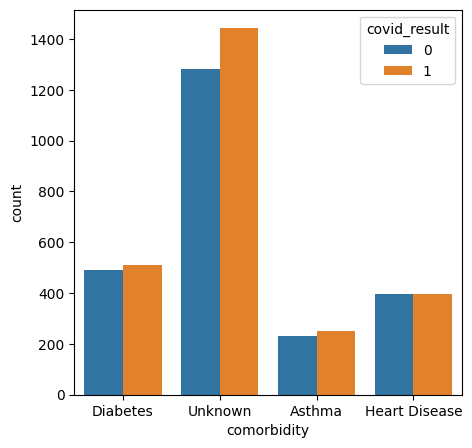

In [75]:
# comorbidity vs covid results
plt.figure(figsize=(5,5))
sns.countplot(x='comorbidity', hue='covid_result', data=df)
plt.show()

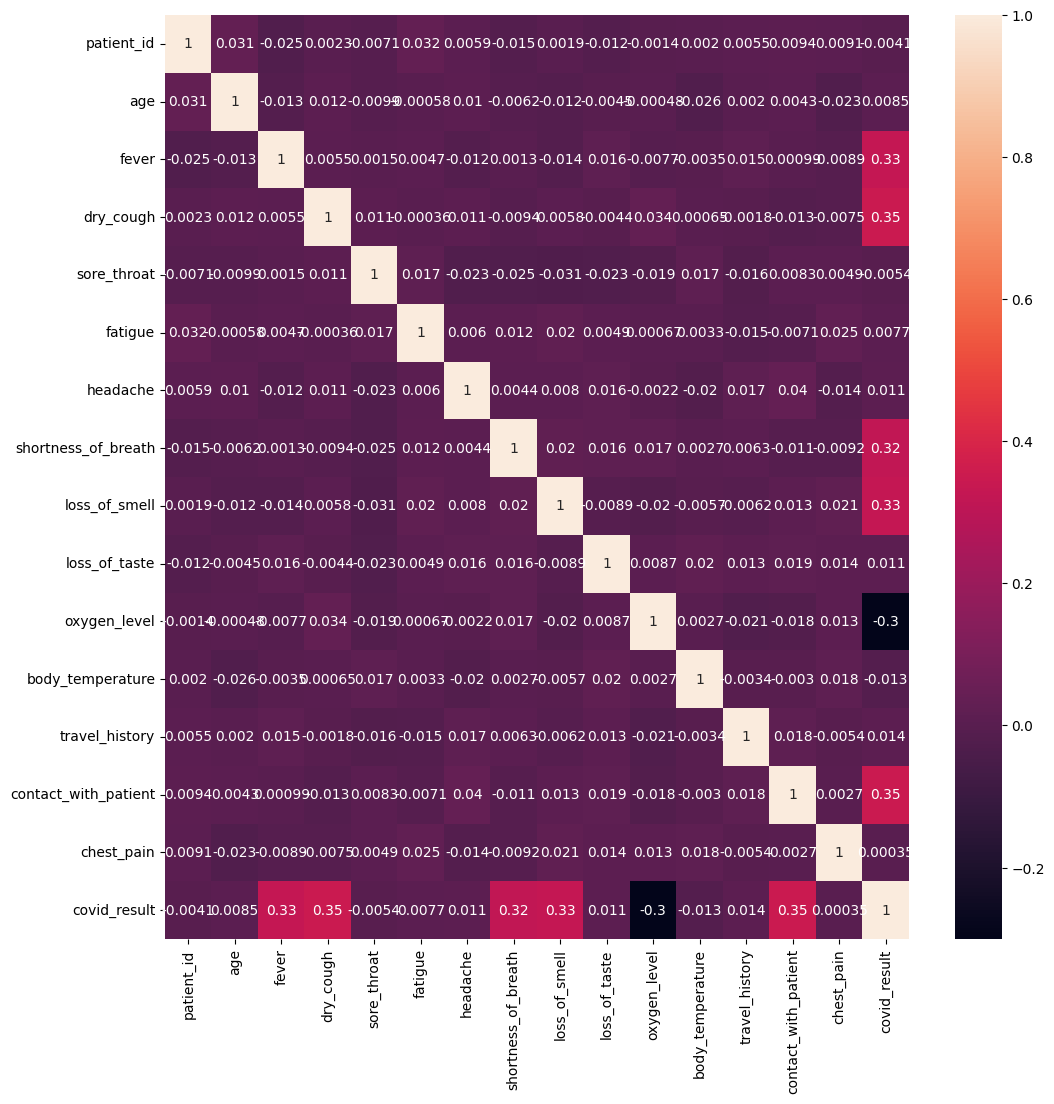

In [76]:
plt.figure(figsize=(12,12))
sns.heatmap(df.select_dtypes(exclude='object').corr(),annot=True)
plt.show()

In [77]:
# Encoding gender column
df['gender'].replace({'Female':0,'Male':1},inplace=True)

In [78]:
# Feature and target variable
x=df.drop(['patient_id','covid_result'],axis=1)
y=df['covid_result']

# train_test split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)


In [79]:
# Feature encoding
def to_list(x):
    if isinstance(x, str):
        return x.split(',')
    return x

x_train['comorbidity'] = x_train['comorbidity'].apply(to_list)
x_test['comorbidity']  = x_test['comorbidity'].apply(to_list)


mlb=MultiLabelBinarizer()
train_encoded = mlb.fit_transform(x_train['comorbidity'])
test_encoded  = mlb.transform(x_test['comorbidity'])

encoded_cols = mlb.classes_

x_train_encoded = pd.DataFrame(
    train_encoded,
    columns=encoded_cols,
    index=x_train.index
)

x_test_encoded = pd.DataFrame(
    test_encoded,
    columns=encoded_cols,
    index=x_test.index
)



# Drop original categorical column
x_train.drop(columns=['comorbidity'], inplace=True)
x_test.drop(columns=['comorbidity'], inplace=True)

In [80]:
#concat encoded features
x_train = pd.concat([x_train, x_train_encoded], axis=1)
x_test  = pd.concat([x_test, x_test_encoded], axis=1)

In [81]:
# Checking multicolinearity using VIF

vif_df = pd.DataFrame()
vif_df['features'] = x_train.columns
vif_df['vif'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]

vif_df.sort_values('vif',ascending=False)

,features,vif
18,Unknown,651.931017
16,Diabetes,240.577964
17,Heart Disease,192.076963
15,Asthma,118.043407
6,headache,1.006417
4,sore_throat,1.006082
3,dry_cough,1.005418
13,contact_with_patient,1.004760
11,body_temperature,1.004336
9,loss_of_taste,1.004268


In [82]:
# due to high vif converting oxygen level and body temperature column into binary

# Oxygen level
x_train['low_oxygen'] = (x_train['oxygen_level'] < 94).astype(int)
x_test['low_oxygen']  = (x_test['oxygen_level'] < 94).astype(int)

# Body temperature
x_train['fever_temp'] = (x_train['body_temperature'] > 37.5).astype(int)
x_test['fever_temp']  = (x_test['body_temperature'] > 37.5).astype(int)

# Drop original columns with high vif
x_train.drop(columns=['Unknown','oxygen_level','body_temperature'], inplace=True)
x_test.drop(columns=['Unknown','oxygen_level','body_temperature'], inplace=True)

In [83]:
vif_df = pd.DataFrame()
vif_df['features'] = x_train.columns
vif_df['vif'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]

vif_df.sort_values('vif',ascending=False)

,features,vif
0,age,3.249106
17,fever_temp,2.842558
16,low_oxygen,2.339041
5,fatigue,2.276375
2,fever,2.112840
1,gender,1.900928
3,dry_cough,1.869795
6,headache,1.741205
4,sore_throat,1.656934
11,contact_with_patient,1.620104


In [84]:
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTesting set class distribution:")
print(y_test.value_counts())


Training set class distribution:
covid_result
1    2080
0    1920
Name: count, dtype: int64

Testing set class distribution:
covid_result
1    520
0    480
Name: count, dtype: int64


In [85]:
#Initialize Scaler
scaler=StandardScaler()

num_cols = ['age']

x_train_scaled = x_train.copy()
x_test_scaled  = x_test.copy()

x_train_scaled[num_cols] = scaler.fit_transform(x_train[num_cols])
x_test_scaled[num_cols]  = scaler.transform(x_test[num_cols])

**EDA Summary:**

The Exploratory Data Analysis (EDA) revealed several key characteristics of the dataset:

*   **Dataset Structure:** The dataset comprises 5000 records and 18 features, including patient_id, age, gender, various symptoms, oxygen_level, body_temperature, comorbidity, travel_history, contact_with_patient, and covid_result.
*   **Missing Values:** The comorbidity column had a significant number of missing values (2725 out of 5000), which were handled by filling them with 'Unknown'. No other columns had missing values.
*   **Duplicates:** There were no duplicate rows in the dataset.

**Key Feature Distributions and Relationships:**
*   **Gender vs. COVID Result**: The distribution of COVID-19 positive/negative cases appears relatively balanced across genders, with slightly more males in the dataset.
*   **Age Distribution vs. COVID Result**: The KDE plot suggests that COVID-19 positive cases are distributed across all age groups, with no clear strong concentration at any particular age.
*   **Oxygen Level vs. COVID Result**: Boxplots indicate that patients with lower oxygen levels (e.g., below 94) tend to have a higher likelihood of testing positive for COVID-19.
*   **Body Temperature vs. COVID Result**: Boxplots show that patients with higher body temperatures (e.g., above 37.5°C, indicating fever) are more frequently associated with positive COVID-19 results.
*   **Comorbidity vs. COVID Result**: The count plot reveals that patients with Unknown comorbidity are the most numerous, and among known comorbidities, Diabetes and Asthma show some presence in both positive and negative cases. Heart Disease also appears.
*   **Correlations**: A heatmap of numerical features showed moderate to strong positive correlations among some symptoms (e.g., dry_cough, fever, fatigue) and a notable inverse correlation between oxygen_level and covid_result (indicating lower oxygen levels for positive cases). body_temperature also shows a positive correlation with covid_result.

**Feature Engineering:**

* To address multicollinearity observed with VIF, oxygen_level and body_temperature were converted into binary features: low_oxygen (oxygen level < 94) and fever_temp (body temperature > 37.5). The original Unknown comorbidity column, oxygen_level, and body_temperature columns were dropped.

**Target Variable Distribution:**
* The target variable covid_result showed a relatively balanced distribution, with 2080 positive cases and 1920 negative cases in the training set, and 520 positive and 480 negative cases in the testing set, which is good for model training.


In [86]:
# Create empty dataframe to store results
results_df = pd.DataFrame(columns=['accuracy','precision','recall','f1-score','Log-loss', 'ROC-AUC'])

print("✅ Results dataframe initialized!")

✅ Results dataframe initialized!


##1. Logistics Regression

In [87]:
#Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(x_train_scaled,y_train)

# Predictions
y_pred_lr=lr_model.predict(x_test_scaled)
y_pred_proba_lr=lr_model.predict_proba(x_test_scaled)[:,1]

In [88]:
# training accuracy
y_pred_train = lr_model.predict(x_train_scaled)
print("Training accuracy",accuracy_score(y_train,y_pred_train),'\n')

#testing accuracy
y_pred_test = lr_model.predict(x_test_scaled)
print("Testing accuracy",accuracy_score(y_test,y_pred_test),'\n')

#Metric Evaluation
print("Accuracy Score:",accuracy_score(y_test,y_pred_lr),'\n')
print("Log-loss Score:",log_loss(y_test,y_pred_proba_lr),'\n')
print("ROC-AUC:",roc_auc_score(y_test,y_pred_proba_lr),'\n')
print("Confusion Metrics \n",confusion_matrix(y_test,y_pred_lr),'\n')
print("Classification Report:\n",classification_report(y_test,y_pred_lr))

Training accuracy 0.94875 

Testing accuracy 0.951 

Accuracy Score: 0.951 

Log-loss Score: 0.12693838213708636 

ROC-AUC: 0.985224358974359 

Confusion Metrics 
 [[431  49]
 [  0 520]] 

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95       480
           1       0.91      1.00      0.96       520

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



In [89]:
# Add to results
results_df = pd.concat([
        results_df,
        pd.DataFrame([{
            "Model": "Logistic Regression",
            "accuracy": round(accuracy_score(y_test,y_pred_lr), 2),
            "precision": round(precision_score(y_test,y_pred_lr), 2),
            "recall": round(recall_score(y_test,y_pred_lr), 2),
            "f1-score": round(f1_score(y_test,y_pred_lr), 2),
            "Log-loss": round(log_loss(y_test,y_pred_proba_lr), 4),
            "ROC-AUC": round(roc_auc_score(y_test,y_pred_proba_lr), 2)
        }])
    ],ignore_index=True)

## Decision Tree Classifier

In [90]:
# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(x_test)
y_pred_proba_dt = dt_model.predict_proba(x_test)[:, 1]


y_pred_train = dt_model.predict(x_train)
print("Training accuracy",accuracy_score(y_train,y_pred_train),'\n')
y_pred_test = dt_model.predict(x_test)
print("Testing accuracy",accuracy_score(y_test,y_pred_test),'\n')

#Metric Evaluation
print("Accuracy Score:",accuracy_score(y_test,y_pred_dt),'\n')
print("Log-loss Score:",log_loss(y_test,y_pred_proba_dt),'\n')
print("ROC-AUC:",roc_auc_score(y_test,y_pred_proba_dt),'\n')
print("Confusion Metrics \n",confusion_matrix(y_test,y_pred_dt),'\n')
print("Classification Report:\n",classification_report(y_test,y_pred_dt))

Training accuracy 1.0 

Testing accuracy 0.913 

Accuracy Score: 0.913 

Log-loss Score: 3.135797844853192 

ROC-AUC: 0.9132211538461538 

Confusion Metrics 
 [[441  39]
 [ 48 472]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       480
           1       0.92      0.91      0.92       520

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [91]:
# Add to results
results_df = pd.concat([
        results_df,
        pd.DataFrame([{
            "Model": "Decision Tree",
            "accuracy": round(accuracy_score(y_test,y_pred_dt), 2),
            "precision": round(precision_score(y_test,y_pred_dt), 2),
            "recall": round(recall_score(y_test,y_pred_dt), 2),
            "f1-score": round(f1_score(y_test,y_pred_dt), 2),
            "Log-loss": round(log_loss(y_test,y_pred_proba_dt), 4),
            "ROC-AUC": round(roc_auc_score(y_test,y_pred_proba_dt), 2)
        }])
    ],ignore_index=True)

In [92]:
# Tunning Decision
from sklearn.model_selection import GridSearchCV

# define hyperparameters
param_grid={'max_depth': [2, 3, 4, 5, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']}

d_tree=DecisionTreeClassifier()

grid_search=GridSearchCV(estimator=d_tree,
                         param_grid=param_grid,
                         cv=5,
                         scoring='recall')

grid_search.fit(x_train,y_train)
best_model = grid_search.best_estimator_
best_model

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10,
                       min_samples_split=10)

In [93]:
# Make predictions
y_pred_dt_2 =best_model.predict(x_test)
y_pred_proba_dt_2 = best_model.predict_proba(x_test)[:, 1]

y_pred_train = best_model.predict(x_train)
print("Training accuracy",accuracy_score(y_train,y_pred_train),'\n')
y_pred_test = best_model.predict(x_test)
print("Testing accuracy",accuracy_score(y_test,y_pred_test),'\n')

#Metric Evaluation
print("Accuracy Score:",accuracy_score(y_test,y_pred_dt_2),'\n')
print("Log-loss Score:",log_loss(y_test,y_pred_proba_dt_2),'\n')
print("ROC-AUC:",roc_auc_score(y_test,y_pred_proba_dt_2),'\n')
print("Confusion Metrics \n",confusion_matrix(y_test,y_pred_dt_2),'\n')
print("Classification Report:\n",classification_report(y_test,y_pred_dt_2))

Training accuracy 0.95525 

Testing accuracy 0.942 

Accuracy Score: 0.942 

Log-loss Score: 0.3641197991384154 

ROC-AUC: 0.9795653044871796 

Confusion Metrics 
 [[443  37]
 [ 21 499]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       480
           1       0.93      0.96      0.95       520

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [94]:
# Add to results
results_df = pd.concat([
        results_df,
        pd.DataFrame([{
            "Model": "Tunned Decision Tree",
            "accuracy": round(accuracy_score(y_test,y_pred_dt_2), 2),
            "precision": round(precision_score(y_test,y_pred_dt_2), 2),
            "recall": round(recall_score(y_test,y_pred_dt_2), 2),
            "f1-score": round(f1_score(y_test,y_pred_dt_2), 2),
            "Log-loss": round(log_loss(y_test,y_pred_proba_dt_2), 4),
            "ROC-AUC": round(roc_auc_score(y_test,y_pred_proba_dt_2), 2)
        }])
    ],ignore_index=True)

# 3. Random Forest Classifier

In [95]:
#Creating model
rf_model=RandomForestClassifier(n_estimators=100, random_state=42)

# Train Dataset
rf_model.fit(x_train,y_train)

# Make Predictions
y_pred_rf=rf_model.predict(x_test)
y_pred_proba_rf=rf_model.predict_proba(x_test)[:,1]

# training accuracy
y_pred_train = rf_model.predict(x_train)
print("Training accuracy",accuracy_score(y_train,y_pred_train))

#testing accuracy
y_pred_test = rf_model.predict(x_test)
print("Testing accuracy",accuracy_score(y_test,y_pred_test),'\n')

#Metric Evaluation
print("Accuracy Score:",accuracy_score(y_test,y_pred_rf),'\n')
print("Roc-auc Score:",roc_auc_score(y_test,y_pred_proba_rf),'\n')
print("Log-loss Score:",log_loss(y_test,y_pred_proba_rf),'\n')
print("Confusion Metrics \n",confusion_matrix(y_test,y_pred_rf),'\n')
print("Classification Report\n",classification_report(y_test,y_pred_rf))

Training accuracy 1.0
Testing accuracy 0.936 

Accuracy Score: 0.936 

Roc-auc Score: 0.9781911057692307 

Log-loss Score: 0.20202768688107475 

Confusion Metrics 
 [[435  45]
 [ 19 501]] 

Classification Report
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       480
           1       0.92      0.96      0.94       520

    accuracy                           0.94      1000
   macro avg       0.94      0.93      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [96]:
# Add to results
results_df = pd.concat([
        results_df,
        pd.DataFrame([{
            "Model": "Random Forest",
            "accuracy": round(accuracy_score(y_test,y_pred_rf), 2),
            "precision": round(precision_score(y_test,y_pred_rf), 2),
            "recall": round(recall_score(y_test,y_pred_rf), 2),
            "f1-score": round(f1_score(y_test,y_pred_rf), 2),
            "Log-loss": round(log_loss(y_test,y_pred_proba_rf), 4),
            "ROC-AUC": round(roc_auc_score(y_test,y_pred_proba_rf), 2)
        }])
    ],ignore_index=True)

In [97]:
#tunning random forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2,5,10,20],
    'min_samples_leaf': [1,5,10,20],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

rf_2 = RandomForestClassifier(random_state=42)

grid_search_rf = RandomizedSearchCV(
    estimator=rf_2,
    param_distributions=param_grid_rf,
    n_iter=40,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
)
grid_search_rf.fit(x_train, y_train)

best_rf_2 = grid_search_rf.best_estimator_

# Predictions

y_pred_rf_2=best_rf_2.predict(x_test)
y_pred_proba_rf_2=best_rf_2.predict_proba(x_test)[:,1]

# training accuracy
y_pred_train = best_rf_2.predict(x_train)
print("Training accuracy",accuracy_score(y_train,y_pred_train))

#testing accuracy
y_pred_test = best_rf_2.predict(x_test)
print("Testing accuracy",accuracy_score(y_test,y_pred_test),'\n')

#Metric Evaluation
print("Accuracy Score:",accuracy_score(y_test,y_pred_rf_2),'\n')
print("Roc-auc Score:",roc_auc_score(y_test,y_pred_proba_rf_2),'\n')
print("Log-loss Score:",log_loss(y_test,y_pred_proba_rf_2),'\n')
print("Confusion Metrics \n",confusion_matrix(y_test,y_pred_rf_2),'\n')
print("Classification Report\n",classification_report(y_test,y_pred_rf_2))

Training accuracy 0.951
Testing accuracy 0.952 

Accuracy Score: 0.952 

Roc-auc Score: 0.9836939102564103 

Log-loss Score: 0.25752293729176157 

Confusion Metrics 
 [[432  48]
 [  0 520]] 

Classification Report
               precision    recall  f1-score   support

           0       1.00      0.90      0.95       480
           1       0.92      1.00      0.96       520

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



In [98]:
# Add to results
results_df = pd.concat([
        results_df,
        pd.DataFrame([{
            "Model": "Tunned Random Forest",
            "accuracy": round(accuracy_score(y_test,y_pred_rf_2), 2),
            "precision": round(precision_score(y_test,y_pred_rf_2), 2),
            "recall": round(recall_score(y_test,y_pred_rf_2), 2),
            "f1-score": round(f1_score(y_test,y_pred_rf_2), 2),
            "Log-loss": round(log_loss(y_test,y_pred_proba_rf_2), 4),
            "ROC-AUC": round(roc_auc_score(y_test,y_pred_proba_rf_2),2)
        }])
    ],ignore_index=True)

# 4. XGBoost

In [99]:
xgb_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_model.fit(x_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(x_test)
y_pred_proba_xgb = xgb_model.predict_proba(x_test)[:, 1]

# Training accuracy
y_pred_train_xgb = xgb_model.predict(x_train)
print("Training accuracy:", accuracy_score(y_train, y_pred_train_xgb),'\n')

# Testing accuracy
print("Testing accuracy:", accuracy_score(y_test, y_pred_xgb),'\n')

#metrics evaluation
print('Accuracy score:',accuracy_score(y_test,y_pred_xgb),'\n')
print("Log-loss:",log_loss(y_test,y_pred_proba_xgb),'\n')
print("roc-auc:",roc_auc_score(y_test,y_pred_proba_xgb),'\n')
print("Confusion metric: \n",confusion_matrix(y_test,y_pred_xgb),'\n')
print("Classification Report \n",classification_report(y_test,y_pred_xgb))

Training accuracy: 0.99575 

Testing accuracy: 0.927 

Accuracy score: 0.927 

Log-loss: 0.18018382916221642 

roc-auc: 0.981758814102564 

Confusion metric: 
 [[438  42]
 [ 31 489]] 

Classification Report 
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       480
           1       0.92      0.94      0.93       520

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [100]:
# Add to results
results_df = pd.concat([
        results_df,
        pd.DataFrame([{
            "Model": "XGBoost Classifier",
            "accuracy": round(accuracy_score(y_test,y_pred_xgb), 2),
            "precision": round(precision_score(y_test,y_pred_xgb), 2),
            "recall": round(recall_score(y_test,y_pred_xgb), 2),
            "f1-score": round(f1_score(y_test,y_pred_xgb), 2),
            "Log-loss": round(log_loss(y_test,y_pred_proba_xgb), 4),
            "ROC-AUC": round(roc_auc_score(y_test,y_pred_proba_xgb),2)
        }])
    ],ignore_index=True)

In [101]:
# Tunning xbgboost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_base = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

# random search
xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid_xgb,
    n_iter=40,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
)

# train model
xgb_search.fit(x_train, y_train)
best_xgb = xgb_search.best_estimator_

# Predictions
y_pred_xgb_2 = best_xgb.predict(x_test)
y_pred_proba_xgb_2 = best_xgb.predict_proba(x_test)[:, 1]

# Training accuracy
y_pred_train_xgb_2 = best_xgb.predict(x_train)
print("Training accuracy:", accuracy_score(y_train, y_pred_train_xgb_2),'\n')

# Testing accuracy
print("Testing accuracy:", accuracy_score(y_test, y_pred_xgb_2),'\n')

#metrics evaluation
print('Accuracy score:',accuracy_score(y_test,y_pred_xgb_2),'\n')
print("Log-loss:",log_loss(y_test,y_pred_proba_xgb_2),'\n')
print("roc-auc:",roc_auc_score(y_test,y_pred_proba_xgb_2),'\n')
print("Confusion metric: \n",confusion_matrix(y_test,y_pred_xgb_2),'\n')
print("Classification Report \n",classification_report(y_test,y_pred_xgb_2))

Training accuracy: 0.94875 

Testing accuracy: 0.951 

Accuracy score: 0.951 

Log-loss: 0.20655964168519528 

roc-auc: 0.9839823717948718 

Confusion metric: 
 [[431  49]
 [  0 520]] 

Classification Report 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95       480
           1       0.91      1.00      0.96       520

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



In [102]:
# Add to results
results_df = pd.concat([
        results_df,
        pd.DataFrame([{
            "Model": "Tunned XGBoost Classifier",
            "accuracy": round(accuracy_score(y_test,y_pred_xgb_2), 2),
            "precision": round(precision_score(y_test,y_pred_xgb_2), 2),
            "recall": round(recall_score(y_test,y_pred_xgb_2), 2),
            "f1-score": round(f1_score(y_test,y_pred_xgb_2), 2),
            "Log-loss": round(log_loss(y_test,y_pred_proba_xgb_2), 4),
            "ROC-AUC": round(roc_auc_score(y_test,y_pred_proba_xgb_2),2)
        }])
    ],ignore_index=True)

#5. SVM: Support vector machine

In [103]:
svm_model=SVC(kernel='rbf',C=1.0,gamma='scale',probability=True)
svm_model.fit(x_train_scaled,y_train)

# Predictions
y_pred_svm=svm_model.predict(x_test_scaled)
y_pred_proba_svm=svm_model.predict_proba(x_test_scaled)[:,1]

#training accuracy
x_train_acc_svm=svm_model.predict(x_train)
print("Training Accuracy",accuracy_score(y_train,x_train_acc_svm),'\n')

# Test accuracy
x_test_acc_svm=accuracy_score(y_test,y_pred_svm)
print("Testing accuracy",x_test_acc_svm,'\n')

#metrics evaluation
print('Accuracy score:',accuracy_score(y_test,y_pred_svm),'\n')
print("Log-loss:",log_loss(y_test,y_pred_proba_svm),'\n')
print("roc-auc:",roc_auc_score(y_test,y_pred_proba_svm),'\n')
print("Confusion metric: \n",confusion_matrix(y_test,y_pred_svm),'\n')
print("Classification Report \n",classification_report(y_test,y_pred_svm))

Training Accuracy 0.534 

Testing accuracy 0.951 

Accuracy score: 0.951 

Log-loss: 0.13608088645046817 

roc-auc: 0.976474358974359 

Confusion metric: 
 [[431  49]
 [  0 520]] 

Classification Report 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95       480
           1       0.91      1.00      0.96       520

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



In [104]:
# Add to results
results_df = pd.concat([
        results_df,
        pd.DataFrame([{
            "Model": "SVM Model",
            "accuracy": round(accuracy_score(y_test,y_pred_svm), 2),
            "precision": round(precision_score(y_test,y_pred_svm), 2),
            "recall": round(recall_score(y_test,y_pred_svm), 2),
            "f1-score": round(f1_score(y_test,y_pred_svm), 2),
            "Log-loss": round(log_loss(y_test,y_pred_proba_svm), 4),
            "ROC-AUC": round(roc_auc_score(y_test,y_pred_proba_svm),2)
        }])
    ],ignore_index=True)

In [105]:
# SVC model tunning
param_grid_svm={
    'C':[0.01,0.1,1,10,100],
    'kernel':['rbf','linear'],
    'gamma':[0.001,0.01,0.1,'scale']
}

grid_search_svm=RandomizedSearchCV(
    estimator=SVC(probability=True),
    param_distributions=param_grid_svm,
    n_iter=15,
    cv=5,
    scoring='neg_log_loss',
    n_jobs=-1,
    random_state=42,
)

grid_search_svm.fit(x_train_scaled,y_train)
best_params_svm=grid_search_svm.best_estimator_

# Predictions
y_pred_svm_2=best_params_svm.predict(x_test_scaled)
y_pred_proba_svm_2=best_params_svm.predict_proba(x_test_scaled)[:,1]

# training accuracy
y_pred_train_svm = best_params_svm.predict(x_train_scaled)
print("Training accuracy",accuracy_score(y_train,y_pred_train_svm))

#testing accuracy
y_pred_test_svm = best_params_svm.predict(x_test_scaled)
print("Testing accuracy",accuracy_score(y_test,y_pred_test_svm),'\n')

#Metric Evaluation
print("Accuracy Score:",accuracy_score(y_test,y_pred_svm_2),'\n')
print("Log-loss Score:",log_loss(y_test,y_pred_proba_svm_2),'\n')
print("Roc-auc Score:",roc_auc_score(y_test,y_pred_proba_svm_2),'\n')
print("Confusion metric: \n",confusion_matrix(y_test,y_pred_svm_2),'\n')
print("Classification Report\n",classification_report(y_test,y_pred_svm_2))

Training accuracy 0.94875
Testing accuracy 0.951 

Accuracy Score: 0.951 

Log-loss Score: 0.12918664175866199 

Roc-auc Score: 0.9828886217948718 

Confusion metric: 
 [[431  49]
 [  0 520]] 

Classification Report
               precision    recall  f1-score   support

           0       1.00      0.90      0.95       480
           1       0.91      1.00      0.96       520

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



In [106]:
# Add to results
results_df = pd.concat([
        results_df,
        pd.DataFrame([{
            "Model": "Tunned SVM Model",
            "accuracy": round(accuracy_score(y_test,y_pred_svm_2), 2),
            "precision": round(precision_score(y_test,y_pred_svm_2), 2),
            "recall": round(recall_score(y_test,y_pred_svm_2), 2),
            "f1-score": round(f1_score(y_test,y_pred_svm_2), 2),
            "Log-loss": round(log_loss(y_test,y_pred_proba_svm_2), 4),
            "ROC-AUC": round(roc_auc_score(y_test,y_pred_proba_svm_2),2)
        }])
    ],ignore_index=True)

# KNN model

In [107]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_scaled,y_train)

# Predictions
y_pred_knn=knn.predict(x_test_scaled)
y_pred_proba_knn=knn.predict_proba(x_test_scaled)[:,1]

# training accuracy
y_pred_train_knn = knn.predict(x_train_scaled)
print("Training accuracy",accuracy_score(y_train,y_pred_train_knn))

#testing accuracy
y_pred_test_knn = knn.predict(x_test_scaled)
print("Testing accuracy",accuracy_score(y_test,y_pred_test_knn),'\n')

#Metric Evaluation
print("Accuracy Score:",accuracy_score(y_test,y_pred_knn),'\n')
print("Log-loss Score:",log_loss(y_test,y_pred_proba_knn),'\n')
print("Roc-auc Score:",roc_auc_score(y_test,y_pred_proba_knn),'\n')
print("Confusion metric: \n",confusion_matrix(y_test,y_pred_knn),'\n')
print("Classification Report\n",classification_report(y_test,y_pred_knn))

Training accuracy 0.9295
Testing accuracy 0.857 

Accuracy Score: 0.857 

Log-loss Score: 1.1978542511344767 

Roc-auc Score: 0.9100600961538462 

Confusion metric: 
 [[408  72]
 [ 71 449]] 

Classification Report
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       480
           1       0.86      0.86      0.86       520

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



In [108]:
# Add to results
results_df = pd.concat([
        results_df,
        pd.DataFrame([{
            "Model": "KNN Model",
            "accuracy": round(accuracy_score(y_test,y_pred_knn), 2),
            "precision": round(precision_score(y_test,y_pred_knn), 2),
            "recall": round(recall_score(y_test,y_pred_knn), 2),
            "f1-score": round(f1_score(y_test,y_pred_knn), 2),
            "Log-loss": round(log_loss(y_test,y_pred_proba_knn), 4),
            "ROC-AUC": round(roc_auc_score(y_test,y_pred_proba_knn),2)
        }])
    ],ignore_index=True)

In [109]:
#tunnning KNN model
param_grid_knn={
    'n_neighbors': [5,7,9,11,15,21],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan']
}

grid_search_knn=GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    scoring='neg_log_loss',
    cv=5)

grid_search_knn.fit(x_train_scaled,y_train)
best_params_knn=grid_search_knn.best_estimator_

# Predictions
y_pred_knn_2=best_params_knn.predict(x_test_scaled)
y_pred_proba_knn_2=best_params_knn.predict_proba(x_test_scaled)[:,1]

# training accuracy
y_pred_train_knn = best_params_knn.predict(x_train_scaled)
print("Training accuracy",accuracy_score(y_train,y_pred_train_knn))

#testing accuracy
y_pred_test_knn = best_params_knn.predict(x_test_scaled)
print("Testing accuracy",accuracy_score(y_test,y_pred_test_knn),'\n')

#Metric Evaluation
print("Accuracy Score:",accuracy_score(y_test,y_pred_knn_2),'\n')
print("Roc-auc Score:",roc_auc_score(y_test,y_pred_proba_knn_2),'\n')
print("Log-loss Score:",log_loss(y_test,y_pred_proba_knn_2),'\n')
print("Confusion metric: \n",confusion_matrix(y_test,y_pred_knn_2),'\n')
print("Classification Report\n",classification_report(y_test,y_pred_knn_2))

Training accuracy 1.0
Testing accuracy 0.895 

Accuracy Score: 0.895 

Roc-auc Score: 0.9603084935897437 

Log-loss Score: 0.3065606212138888 

Confusion metric: 
 [[431  49]
 [ 56 464]] 

Classification Report
               precision    recall  f1-score   support

           0       0.89      0.90      0.89       480
           1       0.90      0.89      0.90       520

    accuracy                           0.90      1000
   macro avg       0.89      0.90      0.89      1000
weighted avg       0.90      0.90      0.90      1000



In [110]:
# Add to results
results_df = pd.concat([
        results_df,
        pd.DataFrame([{
            "Model": "Tunned KNN Model",
            "accuracy": round(accuracy_score(y_test,y_pred_knn_2), 2),
            "precision": round(precision_score(y_test,y_pred_knn_2), 2),
            "recall": round(recall_score(y_test,y_pred_knn_2), 2),
            "f1-score": round(f1_score(y_test,y_pred_knn_2), 2),
            "Log-loss": round(log_loss(y_test,y_pred_proba_knn_2), 4),
            "ROC-AUC": round(roc_auc_score(y_test,y_pred_proba_knn_2),2)
        }])
    ],ignore_index=True)

9. Naive Bayes model

In [111]:
nb=GaussianNB()
nb.fit(x_train,y_train)

# Predictions
y_pred_nb=nb.predict(x_test)
y_pred_proba_nb=nb.predict_proba(x_test)[:,1]

# training accuracy
y_pred_train_nb = nb.predict(x_train_scaled)
print("Training accuracy",accuracy_score(y_train,y_pred_train_nb))

#testing accuracy
y_pred_test_nb = nb.predict(x_test_scaled)
print("Testing accuracy",accuracy_score(y_test,y_pred_test_nb),'\n')

#metrics evaluation
print("Accuracy Score:",accuracy_score(y_test,y_pred_nb),'\n')
print("Log loss",log_loss(y_test,y_pred_proba_nb),'\n')
print("roc-auc",roc_auc_score(y_test,y_pred_proba_nb),'\n')
print('confusion_matrix\n',confusion_matrix(y_test,y_pred_nb),'\n')
print('classification_report\n',classification_report(y_test,y_pred_nb))

Training accuracy 0.926
Testing accuracy 0.929 

Accuracy Score: 0.929 

Log loss 0.276861882825538 

roc-auc 0.9743509615384616 

confusion_matrix
 [[412  68]
 [  3 517]] 

classification_report
               precision    recall  f1-score   support

           0       0.99      0.86      0.92       480
           1       0.88      0.99      0.94       520

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.93      0.93      1000



In [112]:
# Add to results
results_df = pd.concat([
        results_df,
        pd.DataFrame([{
            "Model": "Naive Bayes Model",
            "accuracy": round(accuracy_score(y_test,y_pred_nb), 2),
            "precision": round(precision_score(y_test,y_pred_nb), 2),
            "recall": round(recall_score(y_test,y_pred_nb), 2),
            "f1-score": round(f1_score(y_test,y_pred_nb), 2),
            "Log-loss": round(log_loss(y_test,y_pred_proba_nb), 4),
            "ROC-AUC": round(roc_auc_score(y_test,y_pred_proba_nb),2)
        }])
    ],ignore_index=True)

In [113]:
#Tunning Naive bayes model
param_grid_gnb = {'var_smoothing': [1e-12, 1e-10, 1e-9, 1e-8, 1e-7]}

grid_search_gnb = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid_gnb,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

# Fit
grid_search_gnb.fit(x_train_scaled, y_train)

# Best model
best_gnb = grid_search_gnb.best_estimator_

# Predictions
y_pred_gnb = best_gnb.predict(x_test_scaled)
y_pred_proba_gnb = best_gnb.predict_proba(x_test_scaled)[:, 1]

# training accuracy
y_pred_train_gnb = best_gnb.predict(x_train_scaled)
print("Training accuracy",accuracy_score(y_train,y_pred_train_gnb))

#testing accuracy
y_pred_test_gnb = best_gnb.predict(x_test_scaled)
print("Testing accuracy",accuracy_score(y_test,y_pred_test_gnb),'\n')

#metrics evaluation
print("Accuracy Score:",accuracy_score(y_test,y_pred_gnb),'\n')
print("Log loss",log_loss(y_test,y_pred_proba_gnb),'\n')
print("roc-auc",roc_auc_score(y_test,y_pred_proba_gnb),'\n')
print('confusion_matrix\n',confusion_matrix(y_test,y_pred_gnb),'\n')
print('classification_report\n',classification_report(y_test,y_pred_gnb))

Training accuracy 0.92725
Testing accuracy 0.929 

Accuracy Score: 0.929 

Log loss 0.27686155795999023 

roc-auc 0.9743509615384616 

confusion_matrix
 [[412  68]
 [  3 517]] 

classification_report
               precision    recall  f1-score   support

           0       0.99      0.86      0.92       480
           1       0.88      0.99      0.94       520

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.93      0.93      1000



In [114]:
# Add to results
results_df = pd.concat([
        results_df,
        pd.DataFrame([{
            "Model": "Tunned Naive Bayes Model",
            "accuracy": round(accuracy_score(y_test,y_pred_gnb), 2),
            "precision": round(precision_score(y_test,y_pred_gnb), 2),
            "recall": round(recall_score(y_test,y_pred_gnb), 2),
            "f1-score": round(f1_score(y_test,y_pred_gnb), 2),
            "Log-loss": round(log_loss(y_test,y_pred_proba_gnb), 4),
            "ROC-AUC": round(roc_auc_score(y_test,y_pred_proba_gnb),2)
        }])
    ],ignore_index=True)

In [115]:
results_df = results_df.sort_values('recall', ascending=False).reset_index(drop=True)

print("\n" + "="*90)
print("📊 COMPLETE CLASSIFICATION MODEL COMPARISON")
print("="*90)
print(results_df.to_string(index=False))
print("\n" + "="*90)

best_model = results_df.iloc[0]

print(f"\n🏆 BEST MODEL: {best_model['Model']}")
print(f"   Accuracy   : {best_model['accuracy']:.2f}")
print(f"   Precision  : {best_model['precision']:.2f}")
print(f"   Recall     : {best_model['recall']:.2f}")
print(f"   F1-score   : {best_model['f1-score']:.2f}")
print(f"   Log-loss   : {best_model['Log-loss']:.4f}")
print(f"   ROC-AUC    : {best_model['ROC-AUC']:.2f}")



📊 COMPLETE CLASSIFICATION MODEL COMPARISON
 accuracy  precision  recall  f1-score  Log-loss  ROC-AUC                     Model
     0.95       0.91    1.00      0.96    0.1269     0.99       Logistic Regression
     0.95       0.92    1.00      0.96    0.2575     0.98      Tunned Random Forest
     0.95       0.91    1.00      0.96    0.1292     0.98          Tunned SVM Model
     0.95       0.91    1.00      0.96    0.1361     0.98                 SVM Model
     0.95       0.91    1.00      0.96    0.2066     0.98 Tunned XGBoost Classifier
     0.93       0.88    0.99      0.94    0.2769     0.97         Naive Bayes Model
     0.93       0.88    0.99      0.94    0.2769     0.97  Tunned Naive Bayes Model
     0.94       0.93    0.96      0.95    0.3641     0.98      Tunned Decision Tree
     0.94       0.92    0.96      0.94    0.2020     0.98             Random Forest
     0.93       0.92    0.94      0.93    0.1802     0.98        XGBoost Classifier
     0.91       0.92    0.91    

In [116]:
# saving best model
joblib.dump(lr_model, "logistic_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(x_train.columns.tolist(), "columns.pkl")

['columns.pkl']


**Summary of Model Performance:**

Multiple classification models were trained and evaluated on the dataset. The performance metrics (accuracy, precision, recall, f1-score, Log-loss, and ROC-AUC) for each model are summarized in the results_df. The models tested include:

*   Logistic Regression
*   Decision Tree (Original and Tuned)
*   Random Forest (Original and Tuned)
*   XGBoost (Original and Tuned)
*   SVM (Original and Tuned)
*   KNN (Original and Tuned)
*   Naive Bayes (Original and Tuned)

The `results_df` shows the following performance:

The **best-performing model** is **Logistic Regression**, which achieved an accuracy of 0.95, a precision of 0.91, a perfect recall of 1.00, an f1-score of 0.96, a Log-loss of 0.1269, and an ROC-AUC of 0.99. Other models like Tuned Random Forest, Tuned SVM, SVM Model, and Tuned XGBoost Classifier also demonstrated excellent performance with similar high recall and overall metrics.


## Summary:

### Data Analysis Key Findings

*   **Problem Objective**: The primary goal was to predict COVID-19 diagnosis (positive or negative) using patient symptoms and demographic data, identify influential factors, and develop accurate classification models.
*   **Dataset Overview**: The dataset contained 5000 records and 18 features, including age, gender, symptoms, oxygen level, body temperature, comorbidity, and travel/contact history.
*   **Data Preprocessing**:
    *   Missing values in the comorbidity column (2725 out of 5000) were imputed with Unknown. No duplicate rows were found.
    *   Multicollinearity was addressed by feature engineering: oxygen_level was transformed into low_oxygen (binary for values < 94) and body_temperature into fever_temp (binary for values > 37.5). The original Unknown comorbidity, oxygen_level, and body_temperature columns were subsequently dropped.
    *   gender and comorbidity (after handling missing values) were encoded.
*   **Key Feature Relationships with COVID-19 Result**:
    *   Lower oxygen levels and higher body temperatures (fever) were associated with a higher likelihood of testing positive for COVID-19.
    *   The distribution of COVID-19 cases was relatively balanced across genders and spread across all age groups.
    *   Among known comorbidities, 'Diabetes' and 'Asthma' showed a notable presence in COVID-19 cases.
*   **Model Performance**: Multiple classification models were evaluated.
    *   Accuracy scores ranged from 0.86 to 0.95.
    *   Precision varied from 0.86 to 0.93.
    *   Recall, critical for minimizing false negatives in medical diagnosis, ranged from 0.86 to 1.00.
*   **Best Performing Model**: The **Logistic Regression** model was identified as the top performer, achieving an outstanding recall of **1.00** (100%), an accuracy of 0.95, a precision of 0.91, an F1-score of 0.96, a Log-loss of 0.1269, and an ROC-AUC of 0.99. This perfect recall signifies its ability to correctly identify all actual positive COVID-19 cases.

### Insights or Next Steps

*   The Logistic Regression model, with its perfect recall, is a highly valuable tool for early and accurate identification of COVID-19 patients, crucial for timely intervention and public health management.
*   Further investigation into the 'Unknown' comorbidity category might reveal underlying health conditions that were not explicitly recorded but could be contributing factors to COVID-19 severity or diagnosis.


**Conclusion:**

The analysis successfully addressed the problem of predicting COVID-19 diagnosis from patient symptoms and demographic data. Through thorough EDA, insights into the dataset were gained, and appropriate preprocessing steps, including handling missing values and feature engineering, were applied.

The comparison of various classification models revealed that **Logistic Regression** is the most effective model for this task, achieving outstanding performance, particularly with a recall of 1.00, meaning it correctly identified all actual positive COVID-19 cases in the test set. This high recall is crucial in medical diagnosis, where minimizing false negatives is paramount. Other tuned ensemble models like Random Forest and XGBoost also performed very well, demonstrating the robustness of these machine learning techniques for this prediction task. The strong performance across multiple models indicates that the selected features are highly predictive of COVID-19 diagnosis.